In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import class_definitions as cd
import function_definitions as fd
import fish_kinematics as fk
import airfoil as ar

from sympy import *
from pathlib import Path

%matplotlib inline
# Global plot parameters
plt.rcParams.update({'font.size':20, 'lines.markersize':9})
plt.rcParams.update({'mathtext.fontset':'cm'})
plt.rcParams.update({'font.family':'Times New Roman'})

The purpose of this notebook is to model the motion of a flapping fish in python but in a way that can be directly translated to an Ansys Fluent UDF function

First we use the airfoil functions to make a NACA0012 airfoil

A fish body can be modeled using the function **naca4(x, t, c, m=0.0, p=0.30, a4=True)** where, 
    **x** is a 1D numpy array of x-coordinates, 
    **c** is the chord length,
    **t** is the maximum thickness,
    **m** is the maximum camber (defaul is symmetric),
    **p** is the location of maximum camber (should be a non-zero number), and 
    **a4** determines if it has an open or closed edge.

In [2]:
chord = 1.0
# half-cosine spacing
beta = np.linspace(0, np.pi, 100)
#dx = (0.5*(1-np.cos(beta)))
# uniform spacing
dx = np.linspace(0.0, chord, 100)
X, Y = ar.naca4(dx, 0.12, 0.0, 0.30, True, chord)
X_airfoil, Y_airfoil = X, Y
x_airfoil, y_airfoil = ar.convert_to_coordinates(X, Y)

(-0.1, 0.1)

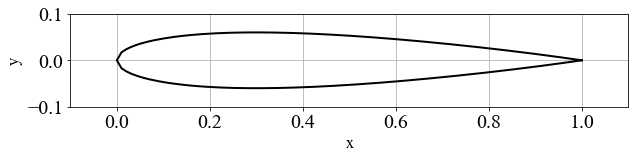

In [3]:
# plot geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_airfoil, y_airfoil, color='k', linestyle='-', linewidth=2)
plt.axis('scaled')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)

Output airfoil to a file for geometry import

Motion as determined by Zhu et al.

- A_h = 0.05 BL
- A_t = 0.15 BL
- x_pivot = 0.3 BL
- frequency = 2.477 Hz
- velocity = 0.3478 ms^-1
- Strouhal = 1.136925

In [4]:
x_head = 0.0
x_com = 0.33
x_tail = 1.0

A_head = 0.02
A_com = 0.05
A_tail = 0.1

# solving for the coefficients
X = np.array([[1, x_head, x_head**2],[1, x_com, x_com**2], [1, x_tail, x_tail**2]])
A = np.array([[A_head], [A_com], [A_tail]])
C = np.linalg.solve(X, A)

# comparing to Maertens method for Carangiform
x = symbols("x")

a = 0.1
C1 = -0.825
C2 = 1.625

expr = a * (1 + ((x-1) * C1) + ((x**2-1) * C2))

print(np.flipud(C.flatten()), simplify(expr))

[-0.01628223  0.09628223  0.02      ] 0.1625*x**2 - 0.0825*x + 0.02


In [5]:
x_head = 0.0
x_com = 0.33
x_tail = 1.0

amplitude_factor = 3

A_head = 0.02 * amplitude_factor
A_com = 0.01047 * amplitude_factor
A_tail = 0.1 * amplitude_factor

# solving for the coefficients
X = np.array([[1, (x_head-1), (x_head**2-1)],
              [1, (x_com-1), (x_com**2-1)], 
              [1, (x_tail-1), (x_tail**2-1)]])
A = np.array([[A_head], [A_com], [A_tail]])
C = np.linalg.solve(X, A)

# comparing to Maertens method for Carangiform
x = symbols("x")

a = 0.1 * amplitude_factor
C1 = -0.825
C2 = 1.625

expr = a * (1 + ((x-1) * C1) + ((x**2-1) * C2))

print(np.flipud(C.flatten()), simplify(expr))

[ 0.48751696 -0.24751696  0.3       ] 0.4875*x**2 - 0.2475*x + 0.06


In [6]:
def carangiform(t, x, amplitude, length, waveNumber, omega):
    x_bl = x / length
    localAmplitude = amplitude[0] * (1 + (x_bl - 1) * amplitude[1] + (np.power(x_bl,2) - 1) * amplitude[2])
    h_dot = np.multiply(-omega * localAmplitude, np.cos(t*omega - waveNumber*x_bl)) * length
    return h_dot

Text(0, 0.5, 'h(x,t) [BL]')

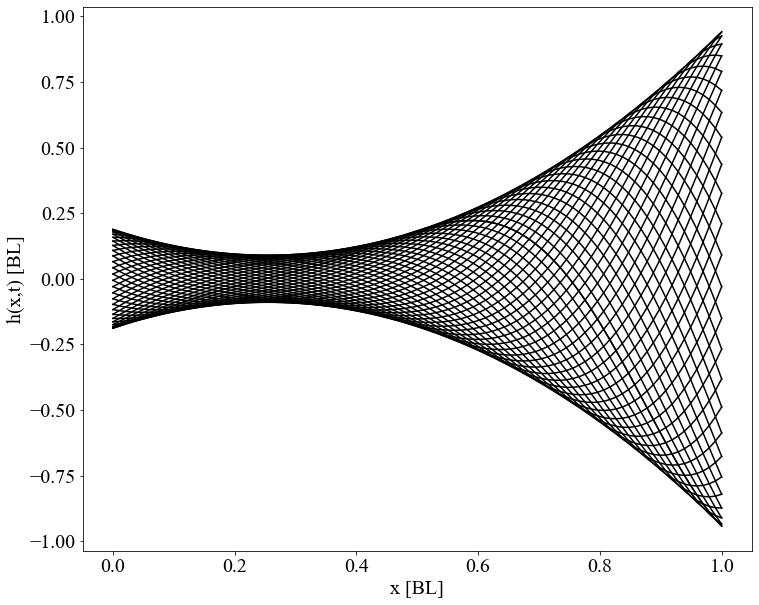

In [7]:
amplitude_ = np.array([0.1, -0.825, 1.625])
length_ = 0.225
St = 0.3
U = 1.0
A_p2p = 0.2
f = St * U / A_p2p
T = 1/f
omega_ = 2 * np.pi * f
lam = 1.0
waveNumber_ = 2*np.pi/lam

time = np.linspace(0, 1*(1/f), 50)

x = np.linspace(0, length_, 100)
x_bl = x / length_

fig1, ax1 = plt.subplots(figsize=(12,10), facecolor='w')

for i, t in enumerate(time):
    y = carangiform(t, x, amplitude_, length_, waveNumber_, omega_)
    ax1.plot(x/length_, y/length_, 'k', label=str(np.round(t/T, 3)))

ax1.set_xlabel('x [BL]')
ax1.set_ylabel('h(x,t) [BL]')
#ax1.set_ylim([-0.15, 0.15])
#ax1.legend(title='t / $\\tau$', ncol=6, bbox_to_anchor=(1.02, 1.15))
#fig1.savefig(Path(r'./figures').joinpath('carangiformMotion.pdf'), facecolor='w', dpi=300, bbox_inches='tight')

[None]

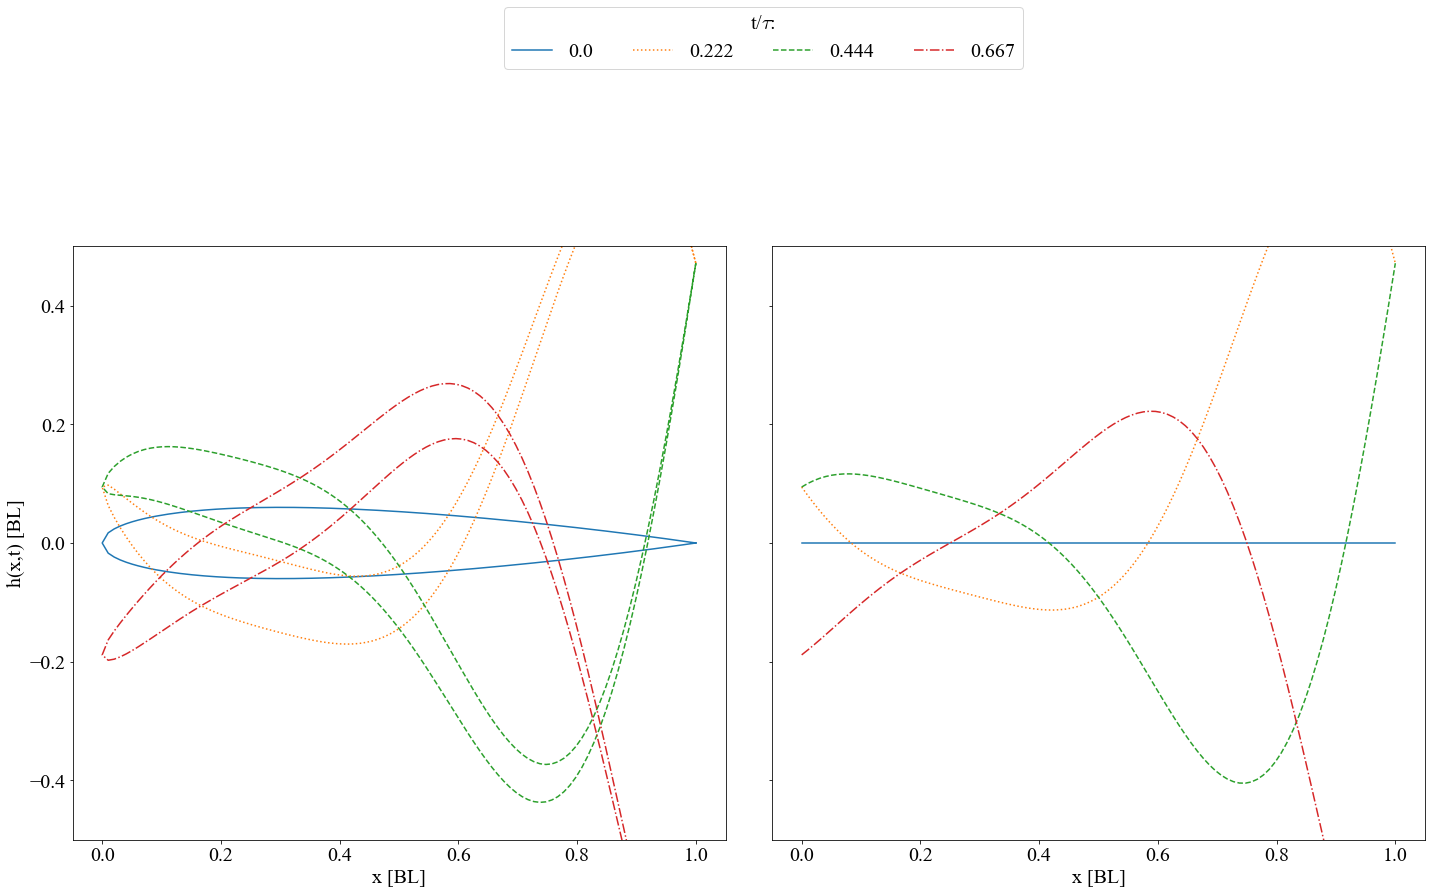

In [8]:
amplitude_ = np.array([0.1, -0.825, 1.625])
length_ = 0.225
St = 0.3
U = 1.0
A_p2p = 0.2
f = St * U / A_p2p
T = 1/f
omega_ = 2 * np.pi * f
lam = 1.0
waveNumber_ = 2*np.pi/lam

time = np.linspace(0, 1*(1/f), 4)

x = np.linspace(0, length_, 100)
y = np.zeros(100)

x_bl = x / length_

fig2, axs = plt.subplots(1, 2, figsize=(20,12), facecolor='w', sharey=True)
fig2.tight_layout()


marker = ['solid', 'dotted', 'dashed', 'dashdot', 'solid']
#x_new, y_new = ar.convert_to_coordinates(X_airfoil, Y_airfoil)

for i, t in enumerate(time):
    if i==0:
        x_new, y_new = ar.convert_to_coordinates(X_airfoil, Y_airfoil)
        axs[0].plot(x_new, y_new, linestyle=marker[i], label=str(np.round(t, 3)))
        axs[1].plot(x/length_, y/length_, linestyle=marker[i], label=str(np.round(t, 3)))
    else:  
        y = carangiform(t, x, amplitude_, length_, waveNumber_, omega_)
        axs[1].plot(x/length_, y/length_, linestyle=marker[i], label=str(np.round(t, 3)))

        y_top = carangiform(t, X_airfoil[0], amplitude_, 1.0, waveNumber_, omega_)
        y_bottom = carangiform(t, X_airfoil[1], amplitude_, 1.0, waveNumber_, omega_)

        Y_new = np.add(Y_airfoil, np.array([y_top, y_bottom]))
        x_new, y_new = ar.convert_to_coordinates(X_airfoil, Y_new)
        axs[0].plot(x_new, y_new, linestyle=marker[i], label=str(np.round(t, 3)))

axs[1].set_xlabel('x [BL]')
axs[1].set_ylim([-0.5, 0.5])
axs[1].set(aspect=1)
axs[1].legend(title = 't/$\\tau$: ', ncol=5, bbox_to_anchor=(0.40, 1.42))

axs[0].set_xlabel('x [BL]')
axs[0].set_ylabel('h(x,t) [BL]')
axs[0].set_ylim([-0.5, 0.5])
axs[0].set(aspect=1)
#fig2.savefig(Path(r'./figures').joinpath('carangiform_visualization.pdf'), facecolor='w', dpi=300, bbox_inches='tight')

In [21]:
def carangiform_tail(t, x, amplitude, length, waveNumber, omega, pivot, maxAngle, phaseAngle):
    x_bl = x/length

    index = x_bl >= pivot
    x_tail = x_bl[index]
    x_body = x_bl[~index]
    
    # calculate body like carangiform    
    localAmplitude = amplitude[0] * (1 + (x_body - 1) * amplitude[1] + (np.power(x_body,2) - 1) * amplitude[2])
    h_dot_foil = amplitude[0] * (amplitude[1]*(pivot-1) + amplitude[2]*(pivot**2 - 1) + 1) * -omega * np.cos(omega * t - waveNumber * pivot) * length
    
    h_dot_body = -omega * np.multiply(localAmplitude, np.cos(waveNumber*x_body - omega*t)) * length

    # Solve for the tail    
    theta_max = np.radians(maxAngle)
    phi = np.radians(phaseAngle)
    
    #-------- y_tail -----------
    # y_tail = y_foilpivot + x_tail * np.tan(theta_t) * length
    
    first_term = -theta_max * omega * np.cos(omega*t - waveNumber*pivot - phi)
    second_term = np.power(1/np.cos(theta_max * np.sin(omega*t-waveNumber*pivot - phi)), 2)

    #h_dot_tail = h_dot_foil + np.multiply(x_tail, np.multiply(first_term, second_term)) * length
    h_dot_tail = np.multiply(np.ones(len(x_tail)), -theta_max * omega * np.cos(omega*t - waveNumber*pivot - phi))*length

    return np.append(h_dot_body, h_dot_tail)

Text(0, 0.5, 'h(x,t) [BL]')

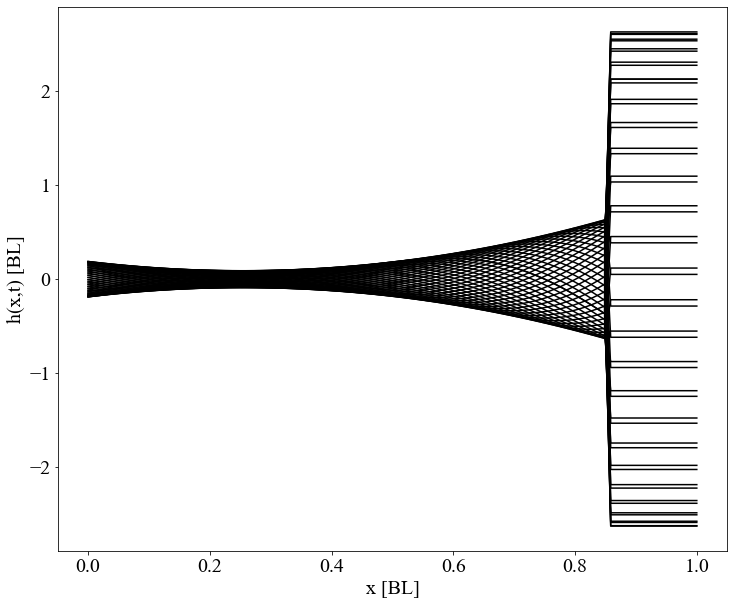

In [22]:
amplitude_ = np.array([0.1, -0.825, 1.625])
length_ = 0.225
St = 0.3
U = 1.0
A_p2p = 0.2
f = St * U / A_p2p
T = 1/f
omega_ = 2 * np.pi * f
lam = 1.0
waveNumber_ = 2*np.pi/lam
pivot_ = 0.85
angle_ = 16
phase_ = -90

time = np.linspace(0, 1*(1/f), 50)

x = np.linspace(0, length_, 100)

fig6, ax6 = plt.subplots(figsize=(12,10))

for i, t in enumerate(time):
    y = carangiform_tail(t, x, amplitude_, length_, waveNumber_, omega_, pivot_, angle_, phase_)
    ax6.plot(x/length_, y/length_, 'k', label=str(np.round(t/T, 3)))

ax6.set_xlabel('x [BL]')
ax6.set_ylabel('h(x,t) [BL]')
#ax6.set_ylim([-0.15, 0.15])
#fig6.savefig(Path(r'./figures').joinpath('thunniformMotion.pdf'), facecolor='w', dpi=300, bbox_inches='tight')

[None]

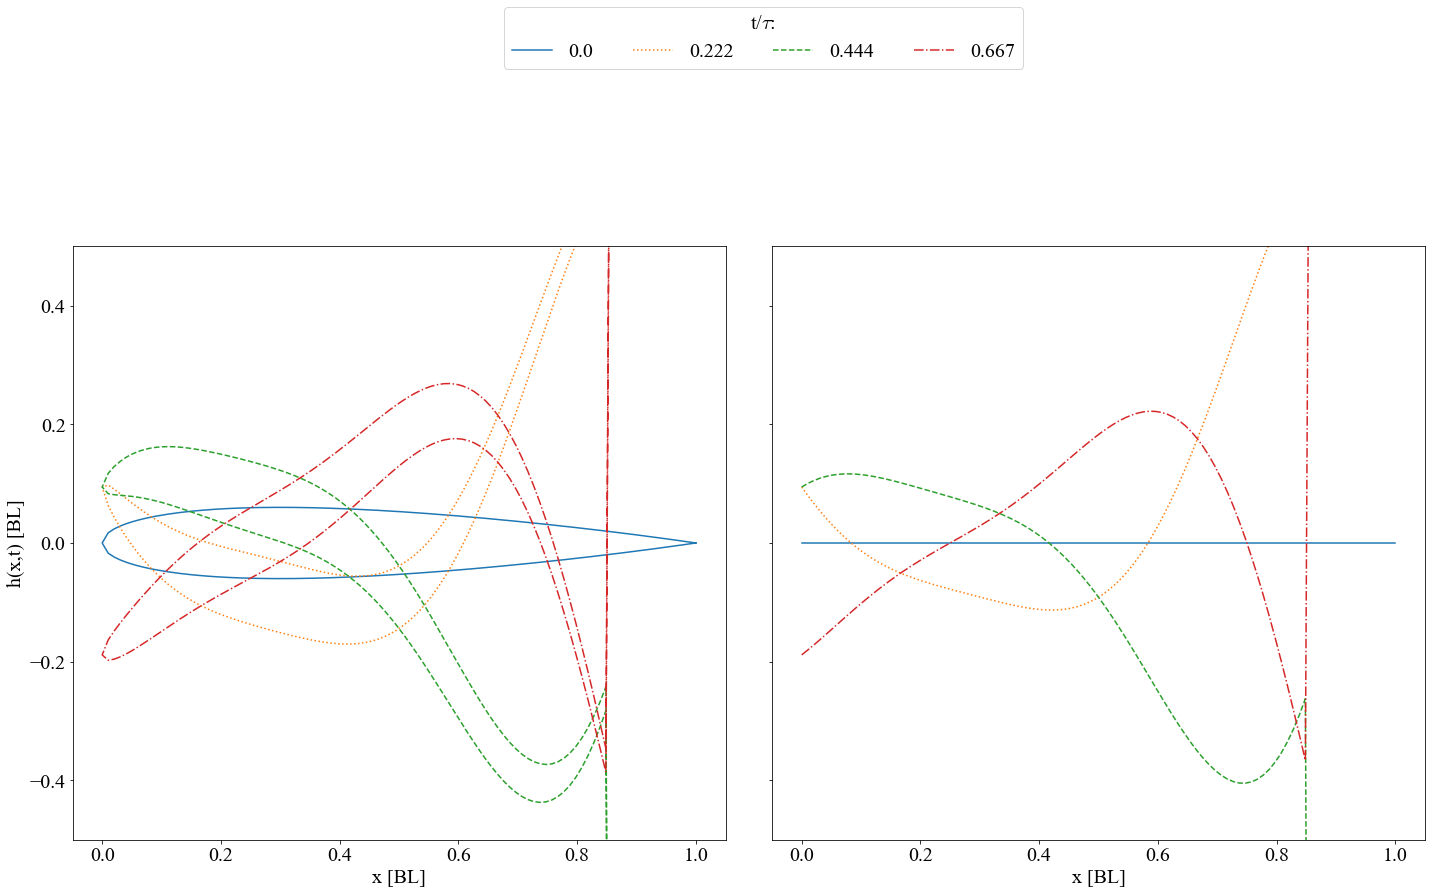

In [11]:
amplitude_ = np.array([0.1, -0.825, 1.625])
length_ = 0.225
St = 0.3
U = 1.0
A_p2p = 0.2
f = St * U / A_p2p
T = 1/f
omega_ = 2 * np.pi * f
lam = 1.0
waveNumber_ = 2*np.pi/lam
pivot_ = 0.85
angle_ = 16
phase_ = -90

time = np.linspace(0, 1*(1/f), 4)

x = np.linspace(0, length_, 100)
y = np.zeros(100)

fig7, axs = plt.subplots(1, 2, figsize=(20,10), facecolor='w', sharey=True)
fig7.tight_layout()

marker = ['solid', 'dotted', 'dashed', 'dashdot', 'solid']

for i, t in enumerate(time):
    if i==0:
        x_new, y_new = ar.convert_to_coordinates(X_airfoil, Y_airfoil)
        axs[0].plot(x_new, y_new, label=str(np.round(t, 3)))
        axs[1].plot(x/length_, y/length_, linestyle=marker[i], label=str(np.round(t, 3)))
    else:    
        y = carangiform_tail(t, x, amplitude_, length_, waveNumber_, omega_, pivot_, angle_, phase_)
        axs[1].plot(x/length_, y/length_, linestyle=marker[i], label=str(np.round(t, 3)))

        y_top = carangiform_tail(t, X_airfoil[0], amplitude_, 1.0, waveNumber_, omega_, pivot_, angle_, phase_)
        y_bottom = carangiform_tail(t, X_airfoil[1], amplitude_, 1.0, waveNumber_, omega_, pivot_, angle_, phase_)

        Y_new = np.add(Y_airfoil, np.array([y_top, y_bottom]))
        x_new, y_new = ar.convert_to_coordinates(X_airfoil, Y_new)
        axs[0].plot(x_new, y_new,  linestyle=marker[i], label=str(np.round(t, 3)))

axs[1].set_xlabel('x [BL]')
#axs[1].set_ylabel('h(x,t) [BL]')
axs[1].set_ylim([-0.5, 0.5])
axs[1].set(aspect=1)

axs[0].set_xlabel('x [BL]')
axs[0].set_ylabel('h(x,t) [BL]')
axs[0].set_ylim([-0.5, 0.5])
axs[1].legend(title = 't/$\\tau$: ', ncol=5, bbox_to_anchor=(0.40, 1.42))
axs[0].set(aspect=1)
#fig7.savefig(Path(r'./figures').joinpath('thunniform_visualization.pdf'), facecolor='w', dpi=300, bbox_inches='tight')

In [12]:
def ostraciiform(t, x, amplitude, length, waveNumber, omega, pivot, maxAngle, phaseAngle):
    x_bl = x / length

    index = np.argwhere(x_bl >= pivot)

    index = x_bl >= pivot
    x_tail = x_bl[index]
    x_body = x_bl[~index]
    
    h_dot_head = amplitude[0] * omega * (amplitude[1] + amplitude[2] -1) * np.cos(omega*t) * length
    h_dot_foil = amplitude[0] * -omega * (amplitude[1]*(pivot-1) + amplitude[2]*(np.power(pivot,2) - 1) + 1) * np.cos(omega * t - waveNumber * pivot) * length

    h_dot_body = np.multiply((h_dot_foil - h_dot_head)/(pivot - 0),x_body) + h_dot_head

    # Solve for the tail    
    theta_max = np.radians(maxAngle)
    phi = np.radians(phaseAngle)

    first_term = -theta_max * omega * np.cos(omega*t - waveNumber*pivot - phi)
    second_term = np.power(np.cos(theta_max * np.sin(omega*t-waveNumber*pivot - phi)), -2)

    h_dot_tail = h_dot_foil + np.multiply(x_tail, np.multiply(first_term, second_term)) * length

    h_dot = np.append(h_dot_body, h_dot_tail)

    return h_dot

Text(0, 0.5, 'h(x,t) [BL]')

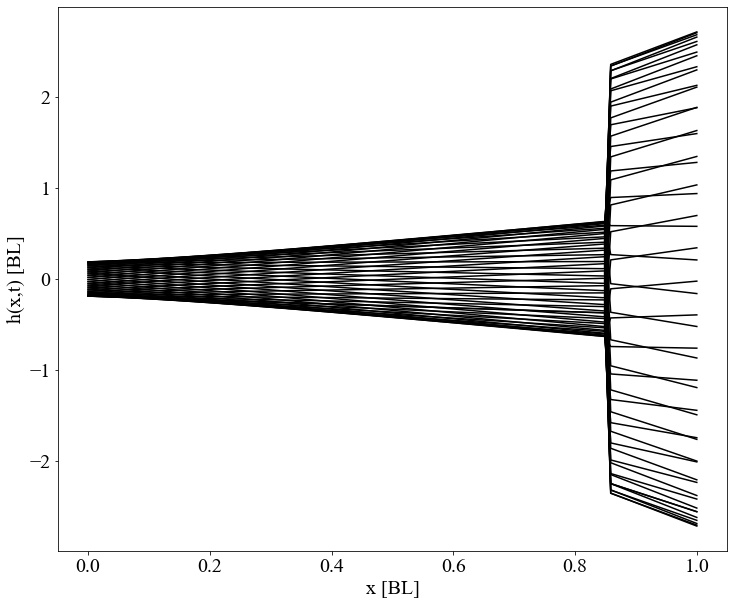

In [13]:
amplitude_ = np.array([0.1, -0.825, 1.625])
length_ = 0.225
St = 0.3
U = 1.0
A_p2p = 0.2
f = St * U / A_p2p
T = 1/f
omega_ = 2 * np.pi * f
lam = 1.0
waveNumber_ = 2*np.pi/lam
pivot_ = 0.85
angle_ = 16
phase_ = 90

time = np.linspace(0, 1*(1/f), 50)

x = np.linspace(0, length_, 100)

fig8, ax8 = plt.subplots(figsize=(12,10))

for i, t in enumerate(time):
    y = ostraciiform(t, x, amplitude_, length_, waveNumber_, omega_, pivot_, angle_, phase_)
    ax8.plot(x/length_, y/length_, 'k', label=str(np.round(t/T, 3)))

ax8.set_xlabel('x [BL]')
ax8.set_ylabel('h(x,t) [BL]')
#fig8.savefig(Path(r'./figures').joinpath('ostraciiformMotion.pdf'), facecolor='w', dpi=300, bbox_inches='tight')

[None]

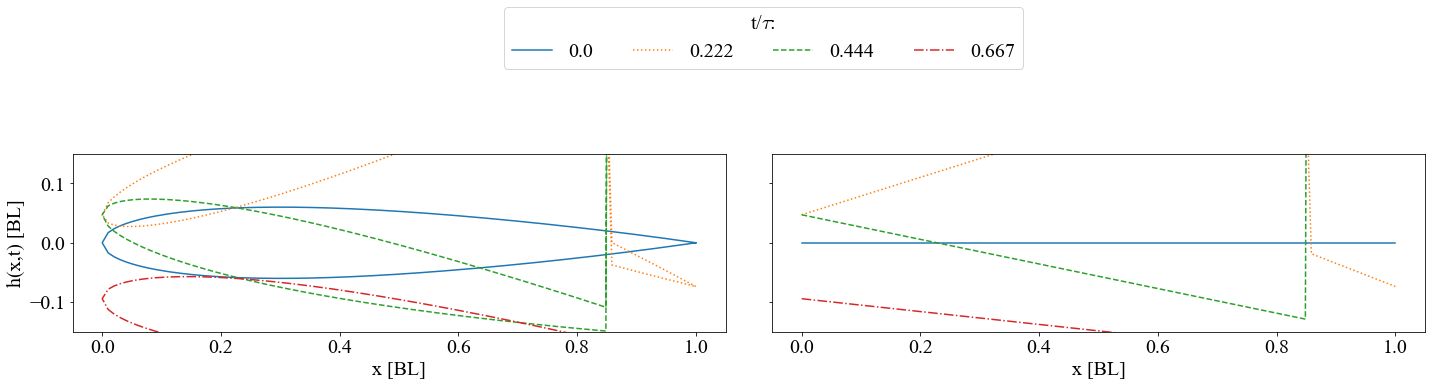

In [14]:
amplitude_ = np.array([0.05, -0.825, 1.625])
length_ = 0.225
St = 0.3
U = 1.0
A_p2p = 0.2
f = St * U / A_p2p
T = 1/f
omega_ = 2 * np.pi * f
lam = 1.0
waveNumber_ = 2*np.pi/lam
pivot_ = 0.85
angle_ = 20
phase_ = 90

time = np.linspace(0, 1*(1/f), 4)

x = np.linspace(0, length_, 100)
y = np.zeros(100)

fig9, axs = plt.subplots(1, 2, figsize=(20,10), facecolor='w', sharey=True)
fig9.tight_layout()

marker = ['solid', 'dotted', 'dashed', 'dashdot', 'solid']

for i, t in enumerate(time):
    if i==0:
        x_new, y_new = ar.convert_to_coordinates(X_airfoil, Y_airfoil)
        axs[0].plot(x_new, y_new,  linestyle=marker[i],label=str(np.round(t, 3)))
        axs[1].plot(x/length_, y/length_,  linestyle=marker[i], label=str(np.round(t, 3)))
    else:    
        y = ostraciiform(t, x, amplitude_, length_, waveNumber_, omega_, pivot_, angle_, phase_)
        axs[1].plot(x/length_, y/length_, linestyle=marker[i], label=str(np.round(t, 3)))

        y_top = ostraciiform(t, X_airfoil[0], amplitude_, 1.0, waveNumber_, omega_, pivot_, angle_, phase_)
        y_bottom = ostraciiform(t, X_airfoil[1], amplitude_, 1.0, waveNumber_, omega_, pivot_, angle_, phase_)
        
        Y_new = np.add(Y_airfoil, np.array([y_top, y_bottom]))
        x_new, y_new = ar.convert_to_coordinates(X_airfoil, Y_new)
        axs[0].plot(x_new, y_new,  linestyle=marker[i], label=str(np.round(t, 3)))

axs[1].set_xlabel('x [BL]')
#axs[1].set_ylabel('h(x,t) [BL]')
axs[1].set_ylim([-0.15, 0.15])
axs[1].set(aspect=1)

axs[0].set_xlabel('x [BL]')
axs[0].set_ylabel('h(x,t) [BL]')
axs[0].set_ylim([-0.15, 0.15])
axs[1].legend(title = 't/$\\tau$: ', ncol=5, bbox_to_anchor=(0.40, 1.42))
axs[0].set(aspect=1)
#fig9.savefig(Path(r'./figures').joinpath('ostraciiform_visualization.pdf'), facecolor='w', dpi=300, bbox_inches='tight')